In [25]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# from entropy import spectral_entropy
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

import itertools

# Load Data

In [43]:
paths = []
labels = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label = folder_name
        label = label.split('_')[0]
        labels.append(label.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'speech': paths,
    'label': labels,
})

# Display the first few rows of the DataFrame to verify
print(df.head())

                                         speech  label
0   data\Recordings\Angry_Female\anger_xn_1.wav  angry
1  data\Recordings\Angry_Female\anger_xn_10.wav  angry
2  data\Recordings\Angry_Female\anger_xn_11.wav  angry
3  data\Recordings\Angry_Female\anger_xn_12.wav  angry
4  data\Recordings\Angry_Female\anger_xn_13.wav  angry


# Data Augmentation

In [3]:
def noise(data, random=True, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, n_steps=pitch_factor, sr=sampling_rate)



# Feature Engineering

In [4]:
n_fft = 2048
hop_length = 512

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)


def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [5]:
def get_features(path, duration=3, offset=0.5):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    # data with pitching
    pitched_data = pitch(data, sample_rate)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, sample_rate)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

Created extra datasets by changing pitch and adding noise, and both

In [6]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.speech, df.label, range(df.speech.shape[0])):
    features = get_features(path)
    if ind % 10 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
10 samples has been processed...
20 samples has been processed...
30 samples has been processed...
40 samples has been processed...
50 samples has been processed...
60 samples has been processed...
70 samples has been processed...
80 samples has been processed...
90 samples has been processed...
100 samples has been processed...
110 samples has been processed...
120 samples has been processed...
130 samples has been processed...
140 samples has been processed...
150 samples has been processed...
160 samples has been processed...
170 samples has been processed...
180 samples has been processed...
190 samples has been processed...
200 samples has been processed...
210 samples has been processed...
220 samples has been processed...
230 samples has been processed...
240 samples has been processed...
250 samples has been processed...
260 samples has been processed...
270 samples has been processed...
280 samples has been processed...
290

In [7]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.head()

# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
print(extracted_df.shape)
print(extracted_df.head())

0         False
1         False
2         False
3         False
4         False
          ...  
2856      False
2857      False
2858      False
2859      False
labels    False
Length: 2861, dtype: bool
(2620, 2861)
          0         1         2         3         4         5         6  \
0  0.024902  0.037109  0.049805  0.049805  0.048340  0.047852  0.049805   
1  0.024902  0.037109  0.051758  0.068359  0.093262  0.147461  0.249512   
2  0.025391  0.042969  0.057617  0.059082  0.053711  0.051270  0.048828   
3  0.024902  0.044922  0.061523  0.091309  0.124512  0.178223  0.270508   
4  0.012207  0.017578  0.022461  0.023438  0.018066  0.017090  0.044922   

          7         8         9  ...  2851  2852  2853  2854  2855  2856  \
0  0.051758  0.049316  0.044922  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.336914  0.413086  0.465820  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.050781  0.057129  0.050781  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.351074  0.424805  0.46630

# Data Preparation

In [36]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [9]:
# Assuming Y is your array of labels
lb = LabelEncoder()
Y_encoded = lb.fit_transform(Y)
num_classes = len(lb.classes_)

# Convert labels to one-hot encoding using tf.keras.utils.to_categorical
Y_one_hot = tf.keras.utils.to_categorical(Y_encoded, num_classes=num_classes)

print(lb.classes_)
print(Y_one_hot)

['angry' 'happy' 'neutral' 'sad']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_one_hot, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Split data into train, test, and validation sets

((2096, 2860), (524, 2860), (2096, 4), (524, 4))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1886, 2860), (524, 2860), (210, 2860), (1886, 4), (524, 4), (210, 4))

In [12]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1886, 2860), (524, 2860), (210, 2860), (1886, 4), (524, 4), (210, 4))

In [13]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1886, 2860, 1)

# Model Training

In [14]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [16]:
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


In [17]:
model = models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=3, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2860, 256)      │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1430, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1430, 128)      │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 715, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 715, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 358, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,865,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,056,900 (23.11 MB)

 Trainable params: 6,056,900 (23.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
EPOCHS = 50
batch_size = 64


history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 752ms/step - acc: 0.2899 - f1_m: 0.0795 - loss: 7.0290 - val_acc: 0.2952 - val_f1_m: 0.1362 - val_loss: 1.4280
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - acc: 0.3589 - f1_m: 0.1036 - loss: 1.3518 - val_acc: 0.3524 - val_f1_m: 0.3122 - val_loss: 1.3230
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - acc: 0.4111 - f1_m: 0.1864 - loss: 1.3020 - val_acc: 0.5048 - val_f1_m: 0.2848 - val_loss: 1.1599
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - acc: 0.4909 - f1_m: 0.3102 - loss: 1.1722 - val_acc: 0.5190 - val_f1_m: 0.2952 - val_loss: 1.1795
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - acc: 0.5924 - f1_m: 0.4514 - loss: 1.0107 - val_acc: 0.5714 - val_f1_m: 0.5568 - val_loss: 1.0047
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 684ms/step - acc: 0.6291 - f1_m: 0.5652 - loss: 0.8985 - val_acc: 0.5476 - val_f1_m: 0.5561 - val_loss: 1.0658
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 644ms/step - acc: 0.7577 - f1_m: 0.7333 

# Model Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - acc: 0.9157 - f1_m: 0.9154 - loss: 0.6937
Accuracy of our model on test data :  90.83969593048096 %


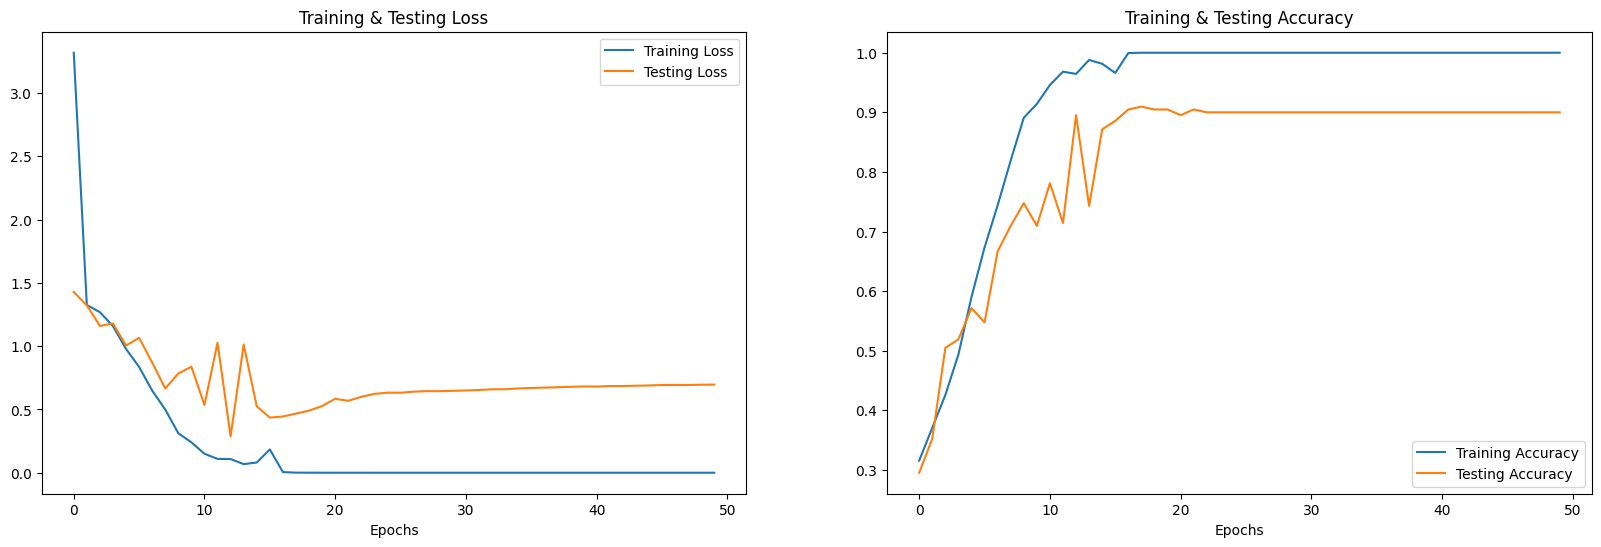

In [30]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [45]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_check = np.argmax(y_test, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


Confusion matrix, without normalization
[[133   9   1   2]
 [  5 124   1   1]
 [  4   6 114   6]
 [  6   4   3 105]]


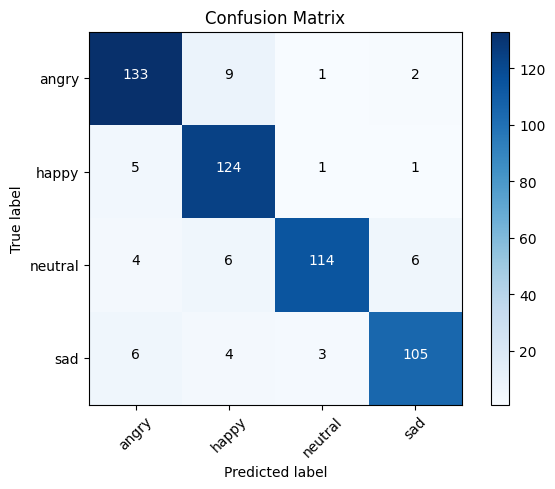

In [39]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have defined y_check and y_pred variables
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Corrected list of class labels with commas
cm_plot_labels = ['angry', 'happy', 'neutral', 'sad']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()
